# **Problem Statement**

Welcome to Green - A country well known for its greenery and natural resources. Green is working towards the betterment of the environment, natural resources, and health of citizens. Over the past few years, Green has improvised its natural resources by enabling the technologies for a safer future. 


The major investment happened to be in renewable energy. As of today, renewable energy contributes to 60% of the total energy capacity in the country. By 2030, the target is to generate 95% of the total energy through renewable energy.


In order to achieve this objective, the government of Green Energy would like to use Data Science to understand the total energy demand of the country in the near future. This will help the government to build the infrastructure and technologies to achieve 95% of the total energy capacity via renewable energy.


They have captured the estimated total energy demand from the past 12 years on an hourly basis. Now, the government of Green Energy is looking for a data scientist to understand the data and forecast the total energy demand for the next 3 years based on past trends.


Help Green! Save Nature! Stay Healthy!

![](https://www.greenesa.com/public/uploads/news/1632327662RenewableenergysourcestypesGreenesa.png)

## **Objective**

The task is to build a model to forecast the total energy demand on an hourly basis for the next 3 years based on past trends.



# 1.0 Importing dependencies



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
data = pd.read_csv('train_IxoE5JN.csv')
data.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


# 2.0 Preprocessing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
data.isna().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

In [ ]:
#converting datetime column to be pandas recognisable datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
#filling in the missing values in energy
data = data.ffill(axis = 0)

In [ ]:
data.tail()

,row_id,datetime,energy
94987,94988,2018-12-31 19:00:00,2528.4468
94988,94989,2018-12-31 20:00:00,2461.8836
94989,94990,2018-12-31 21:00:00,2365.9944
94990,94991,2018-12-31 22:00:00,2342.9428
94991,94992,2018-12-31 23:00:00,2180.2176


In [ ]:
max = data['datetime'].max()
min = data['datetime'].min()
max - min

Timedelta('3957 days 23:00:00')

In [ ]:
(3957*24)+24

94992

## 1 Pre-processing Insights
- datetime is considered as object. converted using pd.datetime
- some null values in Energy. will use pandas fill method
- Total number rows in train data = number of hours from start and end date i.e. there is no time jump between consecutive rows

## 2 Distribution over hours/days/months/years

In [ ]:
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.dayofweek #It is assumed the week starts on Monday, which is denoted by 0
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

In [ ]:
data.head()

,row_id,datetime,energy,hour,day,month,year
0,1,2008-03-01 00:00:00,1259.985563,0,5,3,2008
1,2,2008-03-01 01:00:00,1095.541500,1,5,3,2008
2,3,2008-03-01 02:00:00,1056.247500,2,5,3,2008
3,4,2008-03-01 03:00:00,1034.742000,3,5,3,2008
4,5,2008-03-01 04:00:00,1026.334500,4,5,3,2008


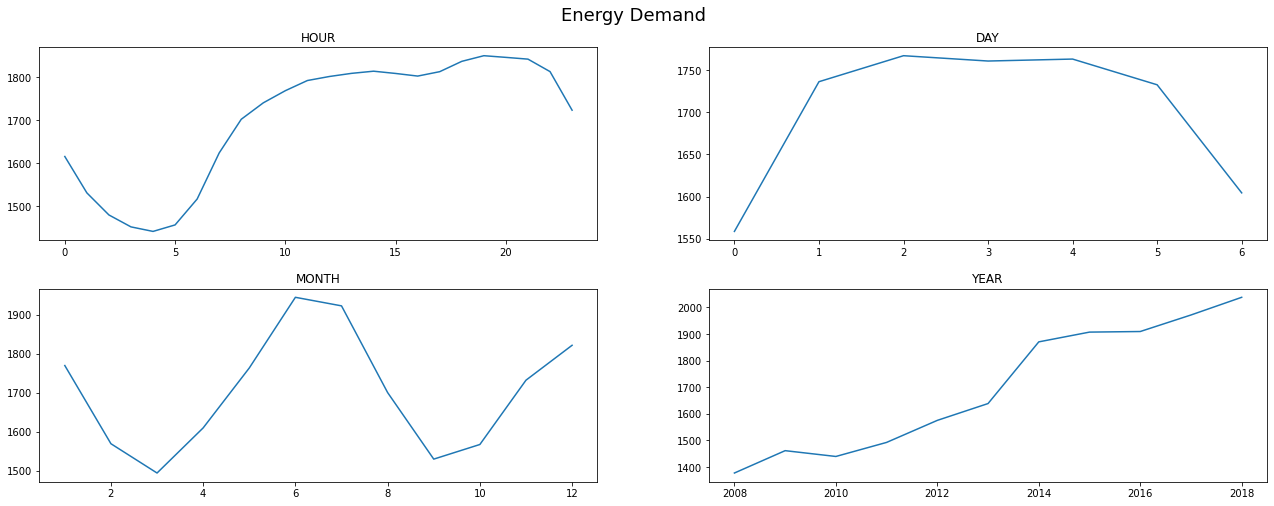

In [ ]:
plt.figure(figsize=(22, 8))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Energy Demand", fontsize=18, y=0.95)
col_list = ['hour', 'day', 'month', 'year']

for n, col in enumerate(col_list):

    # add a new subplot iteratively
    ax = plt.subplot(2, 2, n + 1)

    # groupby on hr/day/month/year and plot vs energy on a new subplot axis
    data.groupby(col)['energy'].mean().plot(ax = ax)

    # chart formatting
    ax.set_title(col.upper())    
    ax.set_xlabel("")

### Insights
- Demand is low during night and fairly constant throughout the day
- Weekends (day 5-6) hav decreasing energy demand
- The energy demand throughout the year is cyclic in nature having its peak in the month of June-July
- The overall trend of energy demand is increasing over the years.

## 3 Outlier detection

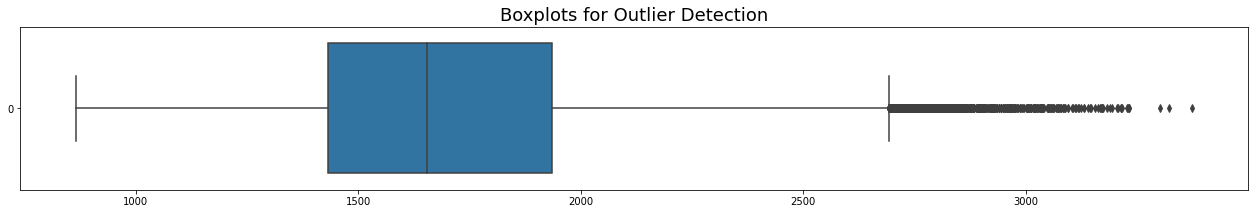

In [ ]:
plt.figure(figsize = (22,3))
ax =sns.boxplot(data = data['energy'], orient="h")
ax.set_title('Boxplots for Outlier Detection', fontsize = 18)
plt.show()

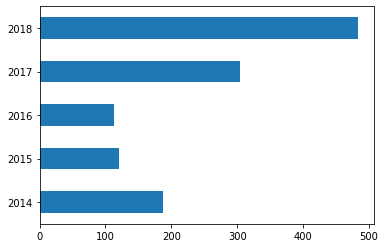

In [ ]:
data[data['energy']>2650]['year'].value_counts().sort_index().plot(kind = 'barh')

### Insights
- Even though from the Box plot it seemed there were some outliers in the data, but if we see the no. of instances wherein the demand is over ~2650 (the upper limit in box plot), only a few times, the limit is crossed.
- These could be due to some festival seasons, cultural events, etc.
- The count is high in the years 2017-2018 which is actually expected as over the years the demand for energy has increased.
- We will not consider these outliers as "Outliers" and will not be removed.

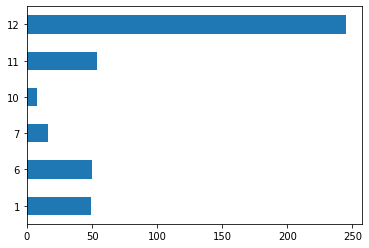

In [ ]:
data[(data['energy']>2650) & (data['year']<2017)]['month'].value_counts().sort_index().plot(kind = 'barh')

- As expected for years prior to 2017, the major energy demand is during the Holiday month of December.

## 4 Energy vs time

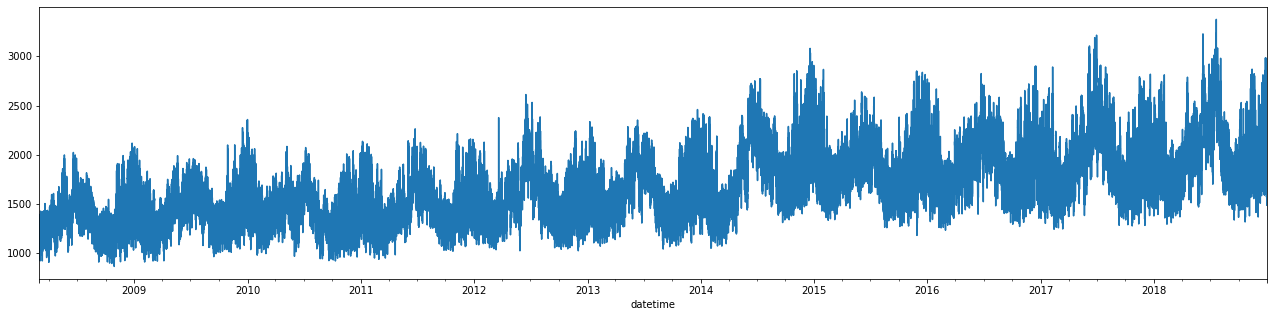

In [ ]:
data.set_index('datetime')['energy'].plot(figsize = (22,5));

# 3.0 Modeling using Prophet

In [ ]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [ ]:
prophet_data = data[['datetime', 'energy']]
prophet_data.columns = ['ds', 'y']

## 1 Base Model

In [ ]:
m = Prophet()

In [ ]:
m.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcqclzpl/swucbsfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcqclzpl/k3kgi53x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99638', 'data', 'file=/tmp/tmpwcqclzpl/swucbsfx.json', 'init=/tmp/tmpwcqclzpl/k3kgi53x.json', 'output', 'file=/tmp/tmpwcqclzpl/prophet_modelntqb5c4c/prophet_model-20221120051129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:11:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
with open('model_01.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model


with open('model_01.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [ ]:
print('no. of hours in 3 years is {}'.format(24*365*3))

no. of hours in 3 years is 26280


In [ ]:
future = m.make_future_dataframe(periods=26280, freq='H')
future

,ds
0,2008-03-01 00:00:00
1,2008-03-01 01:00:00
2,2008-03-01 02:00:00
3,2008-03-01 03:00:00
4,2008-03-01 04:00:00
...,...
121267,2021-12-30 19:00:00
121268,2021-12-30 20:00:00
121269,2021-12-30 21:00:00
121270,2021-12-30 22:00:00


In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-03-01 00:00:00,1468.616317,1012.029240,1458.810559,1468.616317,1468.616317,-244.227616,-244.227616,-244.227616,-78.577788,...,54.331651,54.331651,54.331651,-219.981480,-219.981480,-219.981480,0.0,0.0,0.0,1224.388701
1,2008-03-01 01:00:00,1468.549799,921.246809,1364.716449,1468.549799,1468.549799,-329.351195,-329.351195,-329.351195,-162.453867,...,53.201363,53.201363,53.201363,-220.098692,-220.098692,-220.098692,0.0,0.0,0.0,1139.198604
2,2008-03-01 02:00:00,1468.483281,841.769151,1311.433445,1468.483281,1468.483281,-394.544928,-394.544928,-394.544928,-226.309688,...,51.980595,51.980595,51.980595,-220.215835,-220.215835,-220.215835,0.0,0.0,0.0,1073.938353
3,2008-03-01 03:00:00,1468.416762,800.481064,1278.210162,1468.416762,1468.416762,-432.974738,-432.974738,-432.974738,-263.301061,...,50.659231,50.659231,50.659231,-220.332908,-220.332908,-220.332908,0.0,0.0,0.0,1035.442024
4,2008-03-01 04:00:00,1468.350244,805.207591,1256.519428,1468.350244,1468.350244,-439.357952,-439.357952,-439.357952,-268.134316,...,49.226273,49.226273,49.226273,-220.449909,-220.449909,-220.449909,0.0,0.0,0.0,1028.992293


### 1 Peformance

In [ ]:
se = np.square(forecast.loc[:94992, 'yhat'] - data['energy'])
mse = np.mean(se)
rmse = np.sqrt(mse)

In [ ]:
print("the RMSE of base model is {}".format(round(rmse,2)))

the RMSE of base model is 173.69


### 2 Plotting the results

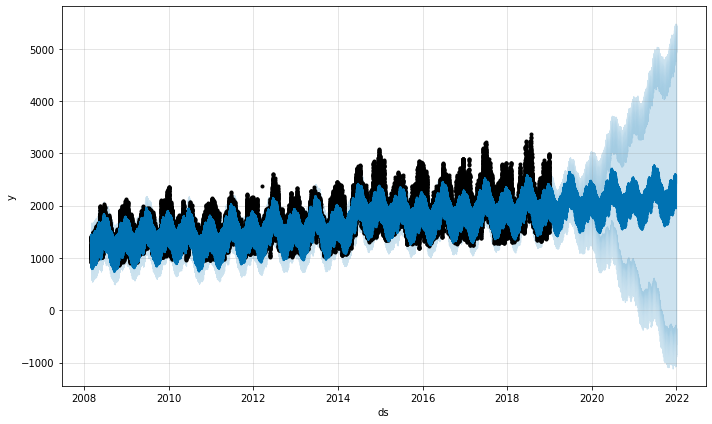

In [ ]:
fig1 = m.plot(forecast)

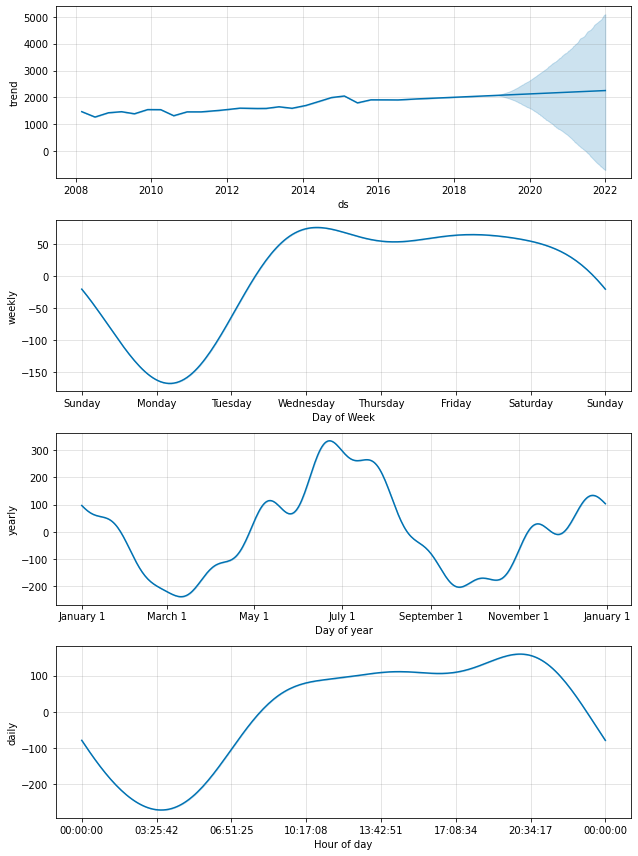

In [ ]:
fig2 = m.plot_components(forecast)

## 2 Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.5, 0.01,0.001],              
              'n_changepoints' : [25, 100, 150]}
grid = ParameterGrid(params_grid)

In [ ]:

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)    
    np.random.seed(42)
    m =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],                         
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,                          
                         interval_width=0.95)    
    m.fit(prophet_data);

    train_forecast = m.make_future_dataframe(periods=26280, freq='H');
    train_forecast = m.predict(train_forecast);    
    test=train_forecast[['ds','yhat']]

    Actual = data.iloc[:data.shape[0], 2:]
    rmse = np.sqrt(mean_squared_error(test.loc[:data.shape[0]-1, 'yhat'], data['energy']))
    print('Root Mean Square Error(RMSE)------------------------------------',round(rmse,2))
    model_parameters = model_parameters.append({'RMSE':rmse,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/7z4sjqw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/awoqylqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51997', 'data', 'file=/tmp/tmp6e2dotu4/7z4sjqw6.json', 'init=/tmp/tmp6e2dotu4/awoqylqw.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model3ljehpcb/prophet_model-20221118094054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 169.26880186591117
{'changepoint_prior_scale': 0.1, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/ux21ielj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/l6lvo6ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97963', 'data', 'file=/tmp/tmp6e2dotu4/ux21ielj.json', 'init=/tmp/tmp6e2dotu4/l6lvo6ck.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model_v9pbvex/prophet_model-20221118094512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 173.53139573618336
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/ujgmelcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/cwq1ctfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42876', 'data', 'file=/tmp/tmp6e2dotu4/ujgmelcp.json', 'init=/tmp/tmp6e2dotu4/cwq1ctfj.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelqk7yjuyq/prophet_model-20221118094901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 164.55944909415166
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/orcmy7zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/w047mr83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53332', 'data', 'file=/tmp/tmp6e2dotu4/orcmy7zv.json', 'init=/tmp/tmp6e2dotu4/w047mr83.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelba68wgjo/prophet_model-20221118100618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 168.02320409749996
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/u1ikep5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/1mc23a9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89414', 'data', 'file=/tmp/tmp6e2dotu4/u1ikep5e.json', 'init=/tmp/tmp6e2dotu4/1mc23a9q.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modele9ydtx7t/prophet_model-20221118101831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 164.69044168687267
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/86n1ev31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/wmgjryzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89598', 'data', 'file=/tmp/tmp6e2dotu4/86n1ev31.json', 'init=/tmp/tmp6e2dotu4/wmgjryzx.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelsk9kxews/prophet_model-20221118103221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 168.1530094612649
{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/j975_aal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/i3l40r32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68838', 'data', 'file=/tmp/tmp6e2dotu4/j975_aal.json', 'init=/tmp/tmp6e2dotu4/i3l40r32.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelyvrezia_/prophet_model-20221118104356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:43:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 169.3024802296817
{'changepoint_prior_scale': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/a2m6ipj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/psi3mh65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91313', 'data', 'file=/tmp/tmp6e2dotu4/a2m6ipj1.json', 'init=/tmp/tmp6e2dotu4/psi3mh65.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelxjacoxh9/prophet_model-20221118104736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 173.55158556582117
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/pvspfedr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/bawr0h9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6919', 'data', 'file=/tmp/tmp6e2dotu4/pvspfedr.json', 'init=/tmp/tmp6e2dotu4/bawr0h9e.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modeljg6ilak7/prophet_model-20221118105120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:59:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 164.99045104066514
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/85iiflec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/qh4u9vr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54919', 'data', 'file=/tmp/tmp6e2dotu4/85iiflec.json', 'init=/tmp/tmp6e2dotu4/qh4u9vr9.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelr_s5jq8p/prophet_model-20221118110049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:00:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:10:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 167.6184694304498
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/2bzil9ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/x5t8nn11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43455', 'data', 'file=/tmp/tmp6e2dotu4/2bzil9ma.json', 'init=/tmp/tmp6e2dotu4/x5t8nn11.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model8sgct8r4/prophet_model-20221118111211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:27:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 163.689619420576
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/oga52fwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/jjbn5qx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78910', 'data', 'file=/tmp/tmp6e2dotu4/oga52fwm.json', 'init=/tmp/tmp6e2dotu4/jjbn5qx3.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model6w4gb9vy/prophet_model-20221118112913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 166.48520629416905
{'changepoint_prior_scale': 0.01, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/g626tg2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/xb2949vw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65959', 'data', 'file=/tmp/tmp6e2dotu4/g626tg2m.json', 'init=/tmp/tmp6e2dotu4/xb2949vw.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model_b23o0uk/prophet_model-20221118115327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 171.6577422292124
{'changepoint_prior_scale': 0.01, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/adguwcjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/jwzmfp8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46301', 'data', 'file=/tmp/tmp6e2dotu4/adguwcjq.json', 'init=/tmp/tmp6e2dotu4/jwzmfp8k.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model8cnph2my/prophet_model-20221118115641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 175.65087045458085
{'changepoint_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/znrqg6fr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/ccwmyc29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10471', 'data', 'file=/tmp/tmp6e2dotu4/znrqg6fr.json', 'init=/tmp/tmp6e2dotu4/ccwmyc29.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modellvrrhwrp/prophet_model-20221118115947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 170.16765021376622
{'changepoint_prior_scale': 0.01, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/dbl7bjgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/n0x3u933.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41030', 'data', 'file=/tmp/tmp6e2dotu4/dbl7bjgf.json', 'init=/tmp/tmp6e2dotu4/n0x3u933.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelw4bwyi58/prophet_model-20221118120747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 174.57055589704143
{'changepoint_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/o6atdy7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/t297o7t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98759', 'data', 'file=/tmp/tmp6e2dotu4/o6atdy7m.json', 'init=/tmp/tmp6e2dotu4/t297o7t0.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelhfe5zda8/prophet_model-20221118121529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 170.141336687271
{'changepoint_prior_scale': 0.01, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/t5l15tn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/qre472sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51619', 'data', 'file=/tmp/tmp6e2dotu4/t5l15tn7.json', 'init=/tmp/tmp6e2dotu4/qre472sy.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model71p30fnb/prophet_model-20221118122500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 174.46157028073392
{'changepoint_prior_scale': 0.001, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/q5fjn68m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/m6jqff1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91627', 'data', 'file=/tmp/tmp6e2dotu4/q5fjn68m.json', 'init=/tmp/tmp6e2dotu4/m6jqff1v.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modeloha8en1v/prophet_model-20221118123456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 177.81560589755514
{'changepoint_prior_scale': 0.001, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/n8b_2shx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/mzbt5a_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15968', 'data', 'file=/tmp/tmp6e2dotu4/n8b_2shx.json', 'init=/tmp/tmp6e2dotu4/mzbt5a_4.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelwlj466w3/prophet_model-20221118123636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 181.09991155340205
{'changepoint_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/0rnwnmsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/aam4w1e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71521', 'data', 'file=/tmp/tmp6e2dotu4/0rnwnmsq.json', 'init=/tmp/tmp6e2dotu4/aam4w1e2.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modeliwykqjsa/prophet_model-20221118123826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 177.058127764644
{'changepoint_prior_scale': 0.001, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/t45z1x8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/b3zrrm33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40761', 'data', 'file=/tmp/tmp6e2dotu4/t45z1x8f.json', 'init=/tmp/tmp6e2dotu4/b3zrrm33.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_modelg3zttwtj/prophet_model-20221118124117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 180.7010625240818
{'changepoint_prior_scale': 0.001, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/4pu2zwix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/u7ralfgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57587', 'data', 'file=/tmp/tmp6e2dotu4/4pu2zwix.json', 'init=/tmp/tmp6e2dotu4/u7ralfgn.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model0mtwdl5r/prophet_model-20221118124359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 177.0084160440324
{'changepoint_prior_scale': 0.001, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/l5jj45hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6e2dotu4/60_djqbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31918', 'data', 'file=/tmp/tmp6e2dotu4/l5jj45hu.json', 'init=/tmp/tmp6e2dotu4/60_djqbn.json', 'output', 'file=/tmp/tmp6e2dotu4/prophet_model4_5zz3ss/prophet_model-20221118124722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 180.54881459101975


## 3 Training Model with minimum RMSE

In [ ]:
best_params = model_parameters[model_parameters['RMSE']==model_parameters['RMSE'].min()]['Parameters'].to_list()
best_params

[{'changepoint_prior_scale': 0.5,
  'n_changepoints': 150,
  'seasonality_mode': 'multiplicative'}]

In [ ]:
np.random.seed(42)
m =Prophet(changepoint_prior_scale = 0.5,                         
                     n_changepoints = 150,
                     seasonality_mode = 'multiplicative',
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,                          
                     interval_width=0.95)    
m.fit(prophet_data);

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcqclzpl/rxa8cozw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwcqclzpl/6bz3fr6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30470', 'data', 'file=/tmp/tmpwcqclzpl/rxa8cozw.json', 'init=/tmp/tmpwcqclzpl/6bz3fr6w.json', 'output', 'file=/tmp/tmpwcqclzpl/prophet_modeluhjw8z8_/prophet_model-20221120053701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
with open('best_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [ ]:
with open('best_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [ ]:
train_forecast = m.make_future_dataframe(periods=26304, freq='H');
train_forecast = m.predict(train_forecast);    
test=train_forecast[['ds','yhat']]

Actual = data.iloc[:data.shape[0], 2:]
rmse = np.sqrt(mean_squared_error(test.loc[:data.shape[0]-1, 'yhat'], data['energy']))
print('Root Mean Square Error(RMSE) :',round(rmse,2))

Root Mean Square Error(RMSE) : 163.69


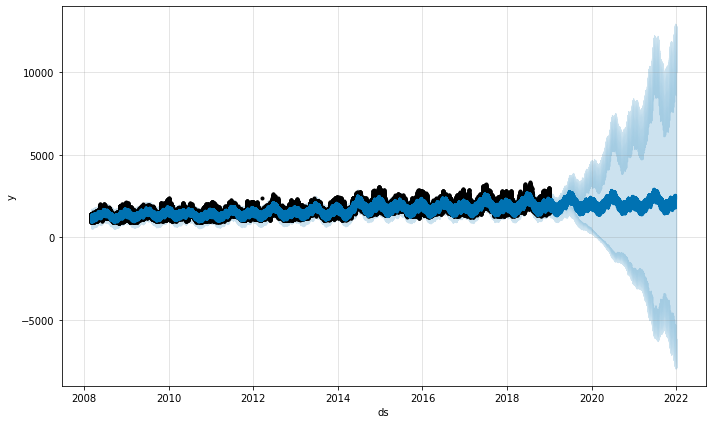

In [ ]:
fig1 = m.plot(train_forecast)

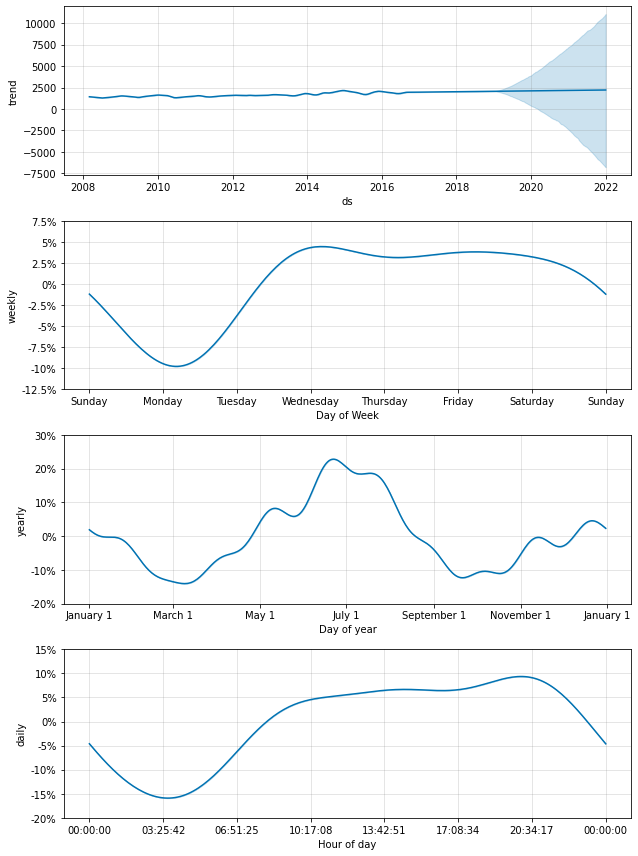

In [ ]:
fig2 = m.plot_components(train_forecast)

In [ ]:
print('The RMSE value is {}% of average energy demand for the last year'.format(round(163.69/(data[data['year']==2018]['energy'].mean())*100, 2)))

The RMSE value is 8.03% of average energy demand for the last year


# 4.0 Forecast Results
- Assumption: The unit of Energy demand is kWh

In [ ]:
demand_2018 = round(data[data['year']==2018]['energy'].sum()/1e6,2)
print('Total Energy Demand for last year is {} GWh'.format(demand_2018))
print('Total Energy demand met by Renewable resources last year is {} GWh'.format(0.6*demand_2018))

Total Energy Demand for last year is 17.85 GWh
Total Energy demand met by Renewable resources last year is 10.71 GWh


In [ ]:
test['year'] = test['ds'].dt.year

forecast_2019 = round(test[test['year']==2019]['yhat'].sum()/1e6, 2)
forecast_2020 = round(test[test['year']==2020]['yhat'].sum()/1e6, 2)
forecast_2021 = round(test[test['year']==2021]['yhat'].sum()/1e6, 2)

demand_incr_2018_19 = round((forecast_2019/demand_2018 - 1) * 100, 2)
demand_incr_2019_20 = round((forecast_2020/forecast_2019- 1) * 100, 2)
demand_incr_2020_21 = round((forecast_2021/forecast_2020- 1) * 100, 2)

forecast = [forecast_2019, forecast_2020, forecast_2021]
demand_incr = [demand_incr_2018_19, demand_incr_2019_20, demand_incr_2020_21]

dict = {
    'year' : range(2019,2022),
    'forecast (GWh)' : forecast,
    'demand_increase (%)' : demand_incr

}

forecast_results = pd.DataFrame(dict)
forecast_results = forecast_results.set_index('year')

In [ ]:
forecast_results

,forecast (GWh),demand_increase (%)
year,,
2019,18.25,2.24
2020,18.74,2.68
2021,19.13,2.08


# 5.0 Conclusion

- There is a **more than 2% demand increase** in energy over the years.
- For the year 2018, 60% of demand i.e. **10.71 GWh** is met by Renewable resources.
- Considering a steady linear growth of going from 60% dependency on Renewable resources to 95% in the year 2030, for the year 2021, around **69%** of demand has to be met by Renewable resources.
- The total forecasted demand for the year 2021 is 19.13 GWh and considering 69% of demand to be met by Renewable resources, the energy demand works out to be **13.2 GWh**.
- This is **23% increase** in demand which needs to be met by Renewable resources.
- Now would be a good time to expand the existing plant capacities or invest in new technologies.

# 6.0 Submission

In [ ]:
data.tail()

,row_id,datetime,energy,hour,day,month,year
94987,94988,2018-12-31 19:00:00,2528.4468,19,0,12,2018
94988,94989,2018-12-31 20:00:00,2461.8836,20,0,12,2018
94989,94990,2018-12-31 21:00:00,2365.9944,21,0,12,2018
94990,94991,2018-12-31 22:00:00,2342.9428,22,0,12,2018
94991,94992,2018-12-31 23:00:00,2180.2176,23,0,12,2018


In [ ]:
submission = test[data.shape[0]:]
submission = submission.reset_index()
submission['index'] = submission['index']+1
submission = submission.drop(['ds', 'year'], axis = 1)
submission.columns = ['row_id', 'energy']

In [ ]:
submission.head()

,row_id,energy
0,94993,1927.190425
1,94994,1835.644500
2,94995,1768.314185
3,94996,1733.501540
4,94997,1737.330932


In [ ]:
submission.to_csv(r'/submission.csv', index=False)

# End